# Customer Segmentation for a Retail Chain -  Part - 3 RFM Analysis

### - Team 3: 
- Sardar Rohan Singh - G01453457
- Bhargav Patel - G01448937
- Saketh - G01425738
- Monisha Jaganathan - G01412067
- Sai Saketh - G01444348

### -  Professor: Eddy Zhang
### -  Course: AIT-614-001 - Big Data Essentials

![](https://imgur.com/40UZPkJ.jpg)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as pyoff
import plotly.graph_objs as go

In [3]:
tx_data = pd.read_excel('retail_chain.xlsx')

In [4]:
tx_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Reviews
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2


In [5]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [6]:
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [54]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Reviews
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3


In [7]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [8]:
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [9]:
tx_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


# Analytical Objectives: Use RFM Analysis for Customer Segmentation
### • Recency: How recently did the customer purchase?
### • Frequency: How often does the customer make purchases?
### • Monetary Value/Margin: How much does the customer spend?
# Note: Segment the best customers/profitable customers for the retail store?

# Recency 

In [10]:
# Recency Value
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()

In [11]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [12]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [13]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [14]:
tx_user.head()

,CustomerID,Recency
0,17850.0,343
1,13047.0,1
2,13748.0,65
3,15100.0,343
4,15291.0,2


In [15]:
tx_user.Recency.describe()

count    2929.000000
mean       67.791738
std        69.759117
min         0.000000
25%        12.000000
50%        45.000000
75%        97.000000
max       343.000000
Name: Recency, dtype: float64

In [16]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

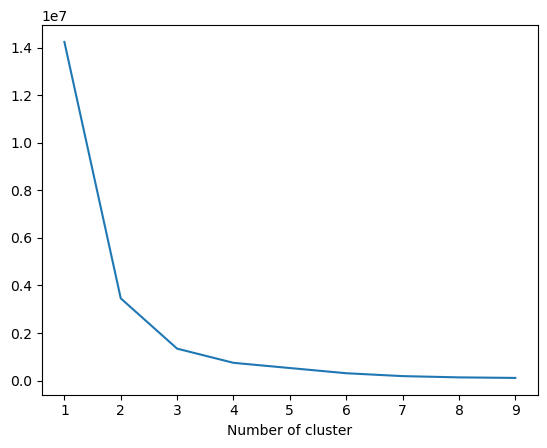

In [17]:
from sklearn.cluster import KMeans


sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [18]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])


In [19]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,500.0,97.250000,15.350139,73.0,84.0,97.0,110.0,125.0
1,944.0,46.884534,11.379616,29.0,37.0,45.0,56.0,71.0
2,483.0,204.051760,31.436880,169.0,182.0,203.0,218.0,343.0
3,1002.0,7.106786,5.314069,0.0,2.0,7.0,12.0,20.0


In [20]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [21]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [22]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,483.0,204.051760,31.436880,169.0,182.0,203.0,218.0,343.0
1,500.0,97.250000,15.350139,73.0,84.0,97.0,110.0,125.0
2,944.0,46.884534,11.379616,29.0,37.0,45.0,56.0,71.0
3,1002.0,7.106786,5.314069,0.0,2.0,7.0,12.0,20.0


# Frequency

In [23]:
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()

In [24]:
tx_frequency.columns = ['CustomerID','Frequency']

In [25]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,31
1,12748.0,1605
2,12749.0,160
3,12820.0,36
4,12821.0,6


In [26]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [27]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,343,0,45
1,15100.0,343,0,1
2,18074.0,343,0,13
3,17420.0,343,0,7
4,16250.0,231,0,24


In [28]:
tx_user.Frequency.describe()

count    2929.000000
mean       59.921475
std       122.364152
min         1.000000
25%        14.000000
50%        31.000000
75%        67.000000
max      4122.000000
Name: Frequency, dtype: float64

In [29]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

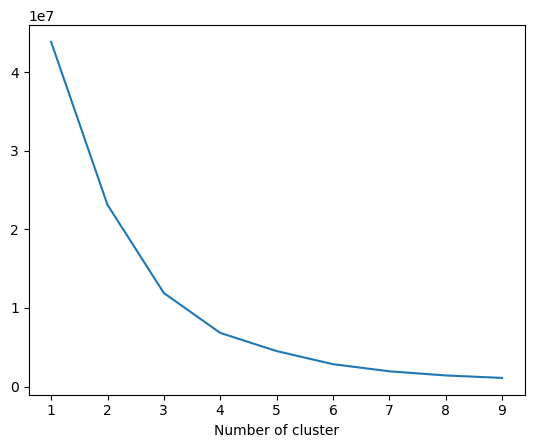

In [30]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [31]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [32]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,381.0,175.910761,64.014656,105.0,127.00,158.0,206.00,397.0
1,2516.0,32.958665,25.921963,1.0,12.00,26.0,48.00,104.0
2,2.0,3228.500000,1263.599818,2335.0,2781.75,3228.5,3675.25,4122.0
3,30.0,636.900000,260.983861,418.0,458.00,543.5,722.25,1605.0


# Use Order_Cluster() 

In [33]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [34]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2516.0,32.958665,25.921963,1.0,12.00,26.0,48.00,104.0
1,381.0,175.910761,64.014656,105.0,127.00,158.0,206.00,397.0
2,30.0,636.900000,260.983861,418.0,458.00,543.5,722.25,1605.0
3,2.0,3228.500000,1263.599818,2335.0,2781.75,3228.5,3675.25,4122.0


# Monetary Value

In [35]:
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']

In [36]:
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [37]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1420.04
1,12748.0,11702.56
2,12749.0,2532.55
3,12820.0,561.53
4,12821.0,92.72


In [38]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [39]:
tx_user.Revenue.describe()

count      2929.000000
mean       1157.761606
std        4093.943296
min       -4287.630000
25%         251.240000
50%         498.740000
75%        1073.800000
max      134943.780000
Name: Revenue, dtype: float64

In [40]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [41]:
import warnings
warnings.filterwarnings("ignore")

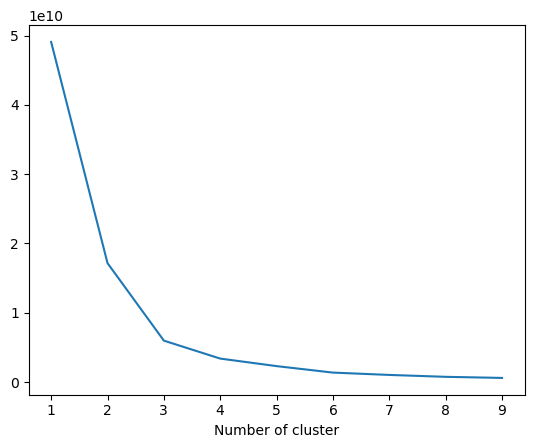

In [42]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [44]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [45]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2746.0,662.344116,610.139977,-4287.63,235.285,451.185,911.9225,2753.23
1,156.0,4908.158788,2145.259258,2802.07,3305.030,4126.925,5850.5725,12239.47
2,25.0,22068.189200,7973.480069,14006.42,17510.060,19755.960,23719.4000,44563.01
3,2.0,127454.650000,10591.229216,119965.52,123710.085,127454.650,131199.2150,134943.78


# Overall Segmentation

In [46]:
tx_user.head(10)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,343,0,45,0,725.44,0
1,15100.0,343,0,1,0,350.40,0
2,18074.0,343,0,13,0,489.60,0
3,17420.0,343,0,7,0,130.85,0
4,16250.0,231,0,24,0,389.44,0
5,17548.0,187,0,10,0,0.00,0
6,15983.0,343,0,29,0,420.35,0
7,17968.0,343,0,41,0,146.17,0
8,16552.0,212,0,12,0,284.44,0
9,12868.0,188,0,29,0,437.52,0


# Find Overall Score 
# Using
# Recency Cluster, Frequency Cluster and Revenue Cluster

In [47]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [48]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,204.220126,19.727463,312.658931
1,98.482105,28.644211,486.505474
2,48.793023,39.839535,690.602108
3,12.111538,53.084615,816.114347
4,10.033333,157.261905,2417.261667
5,7.494737,231.473684,5781.053474
6,5.043478,476.347826,12672.033043
7,2.428571,628.285714,55846.405714
8,4.500000,3228.500000,20580.850000


In [49]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    477
1    475
2    860
3    780
4    210
5     95
6     23
7      7
8      2
Name: Recency, dtype: int64

In [50]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [51]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [52]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [53]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# END OF PART 3 AND PROJECT